In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

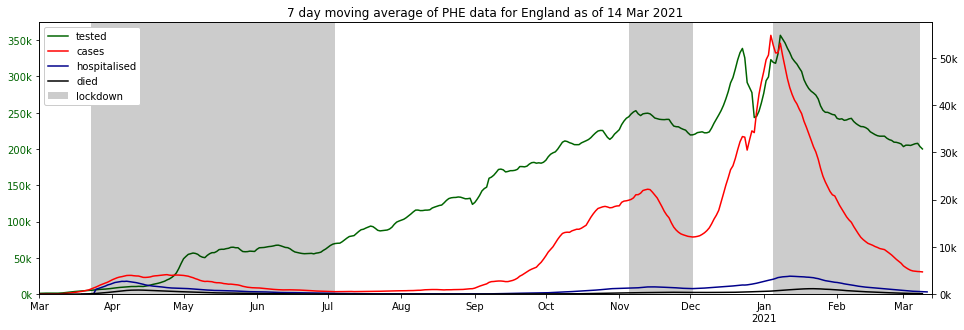

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum,),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

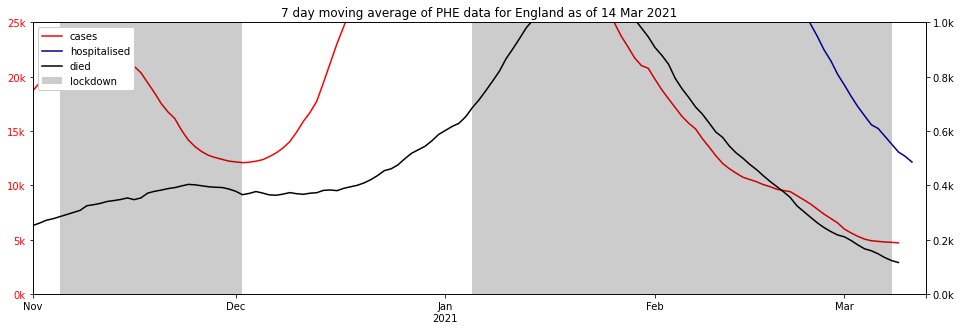

In [13]:
plot_summary(earliest_date='2020-11-01',
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=25_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=1_000)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,1115066.0,20568821.0,19453755.0,56286961,1.981038,34.561743,63.457219
1,Northern Ireland,N92000002,52407.0,625195.0,572788.0,1893667,2.767488,30.247557,66.984956
2,Scotland,S92000003,160038.0,1888697.0,1728659.0,5463300,2.929328,31.641297,65.429374
3,Wales,W92000004,257398.0,1113498.0,856100.0,3152879,8.163904,27.152961,64.683136


'partial: 24,196,211 (36.2%), full: 1,584,909'

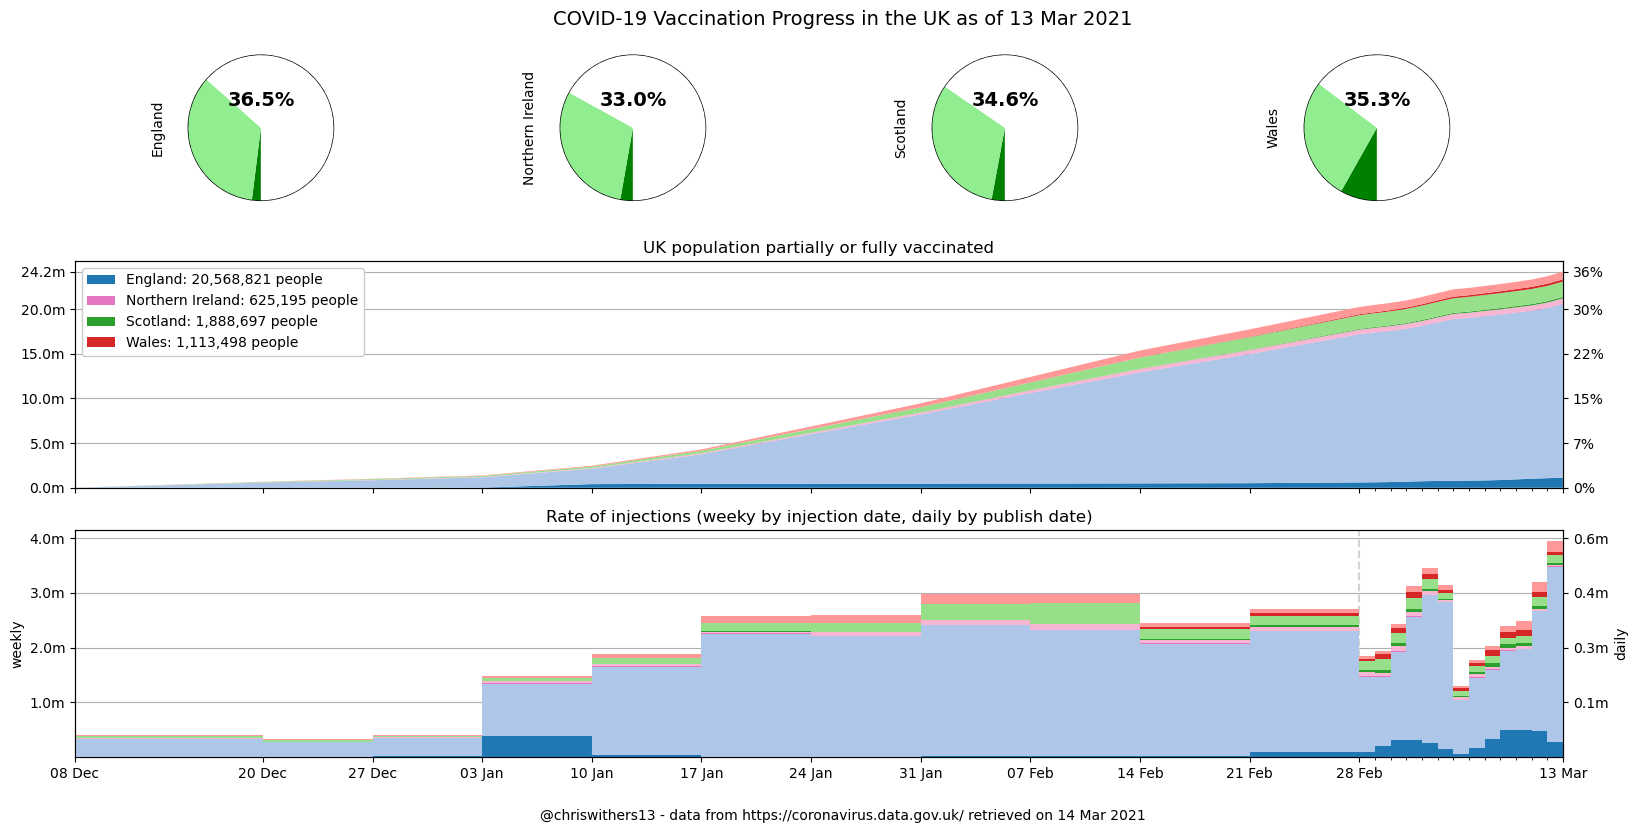

In [4]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,13 Mar 21,"+457,632","+38,640","+38,640","+20,568,821","+1,115,066","+1,115,066"
Northern Ireland,13 Mar 21,"+3,733","+2,355","+2,355","+625,195","+52,407","+52,407"
Scotland,13 Mar 21,"+21,574","+3,788","+3,788","+1,888,697","+160,038","+160,038"
Wales,13 Mar 21,"+29,169","+7,372","+7,372","+1,113,498","+257,398","+257,398"


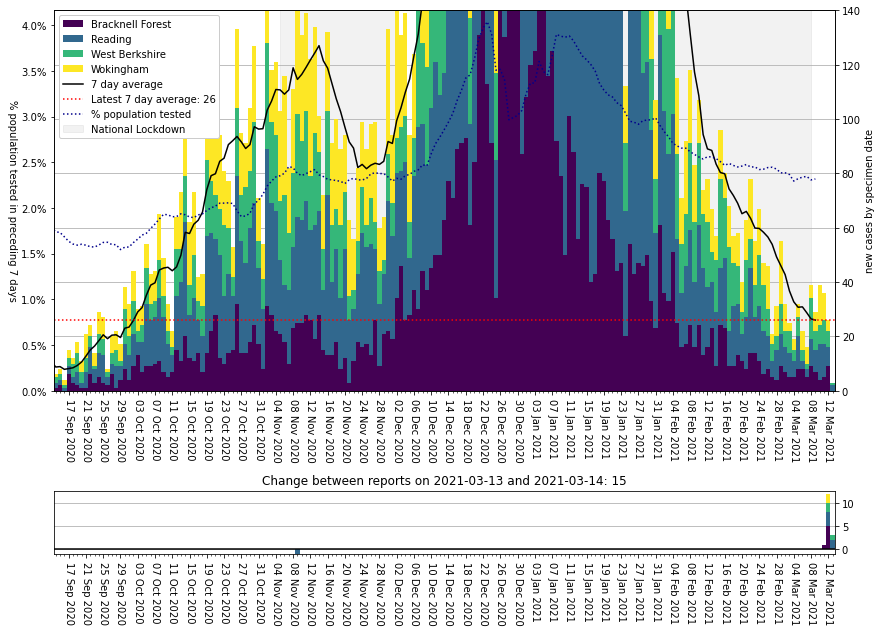

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140)

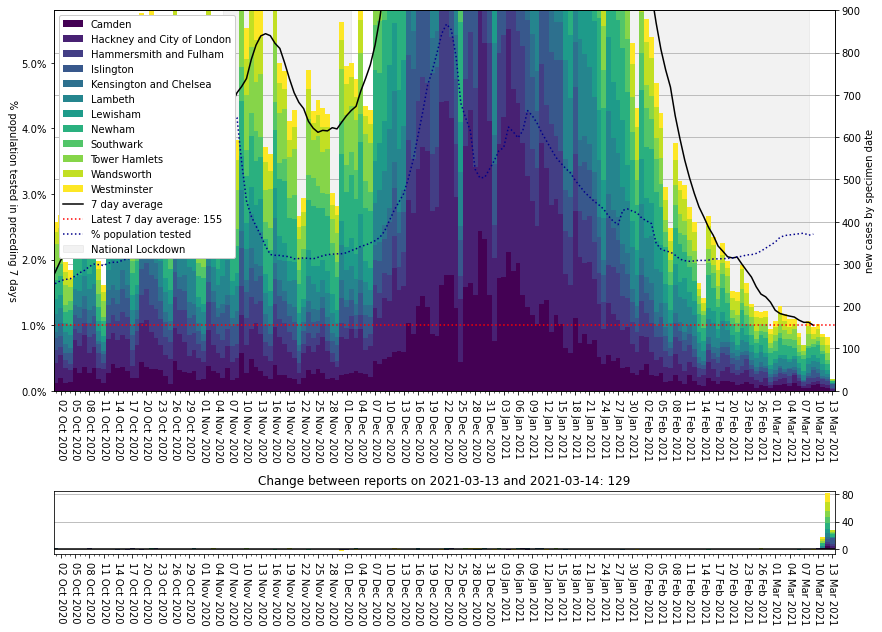

In [7]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,160.624775,116.0,2021-03-13
E06000010,"Kingston upon Hull, City of",155.902347,405.0,2021-03-13
E08000016,Barnsley,141.777320,350.0,2021-03-13
E07000236,Redditch,140.744303,120.0,2021-03-13
W06000024,Merthyr Tydfil,137.585784,83.0,2021-03-13
E06000012,North East Lincolnshire,136.623152,218.0,2021-03-13
E08000032,Bradford,129.312900,698.0,2021-03-13
E07000123,Preston,122.262200,175.0,2021-03-13
S12000049,Glasgow City,122.093758,773.0,2021-03-13


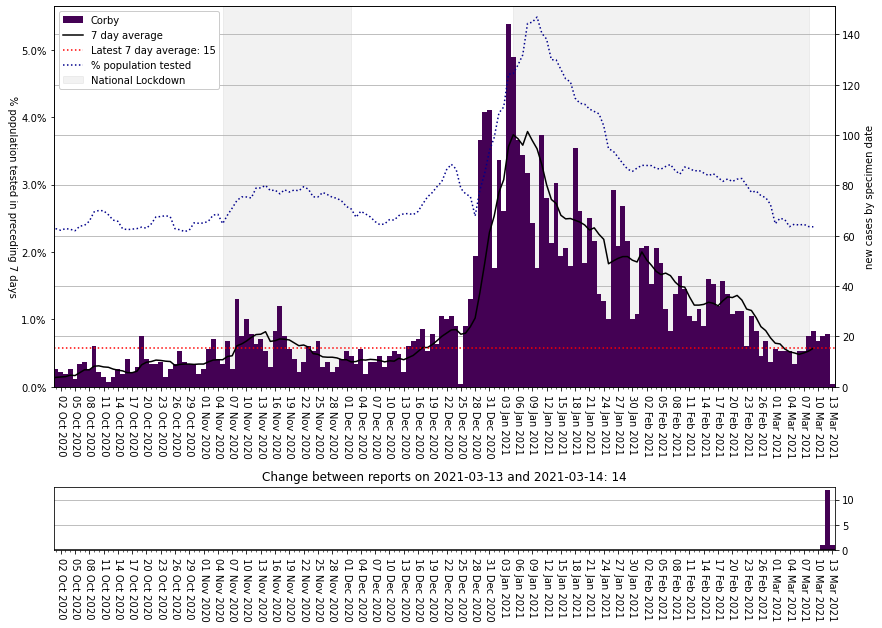

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000049,Glasgow City,122.093758,773.0,2021-03-13
E08000025,Birmingham,67.261275,768.0,2021-03-13
E08000035,Leeds,93.678409,743.0,2021-03-13
E08000032,Bradford,129.312900,698.0,2021-03-13
E08000019,Sheffield,86.517467,506.0,2021-03-13
E08000003,Manchester,81.576101,451.0,2021-03-13
E06000010,"Kingston upon Hull, City of",155.902347,405.0,2021-03-13
E08000036,Wakefield,114.552470,399.0,2021-03-13
S12000050,North Lanarkshire,113.073791,386.0,2021-03-13


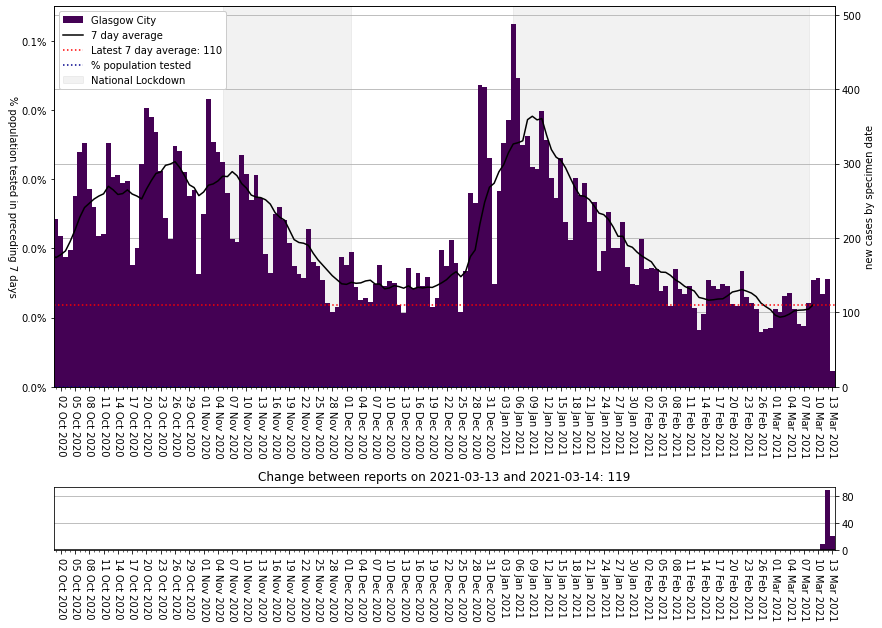

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.2

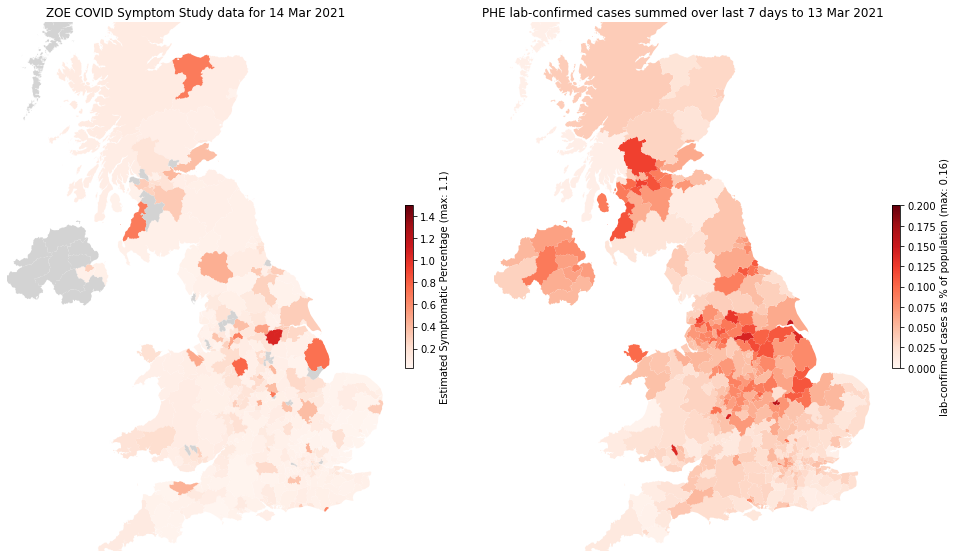

In [14]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

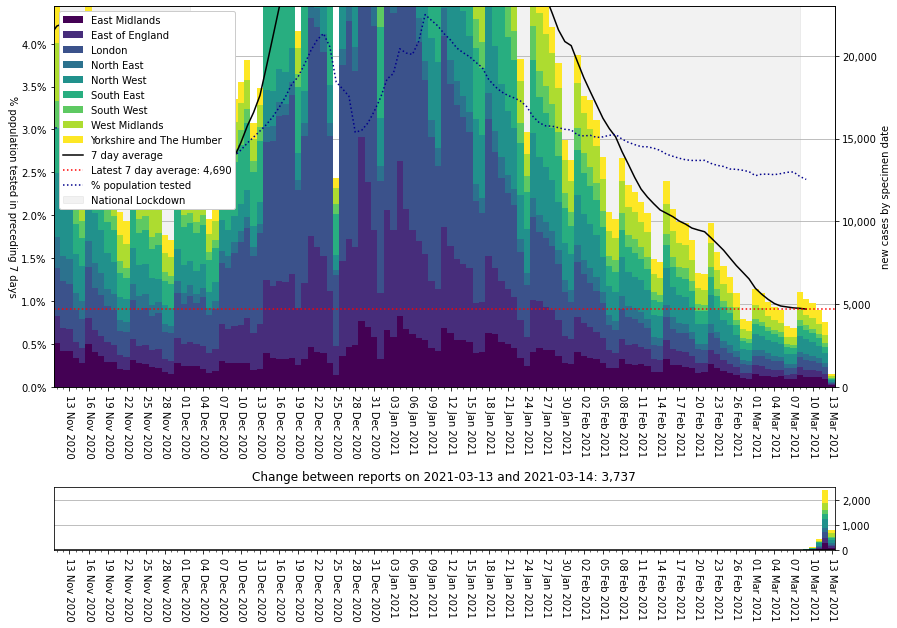

In [16]:
plot_areas(for_date, area_type=region, ylim=23_000, earliest='2020-11-11')

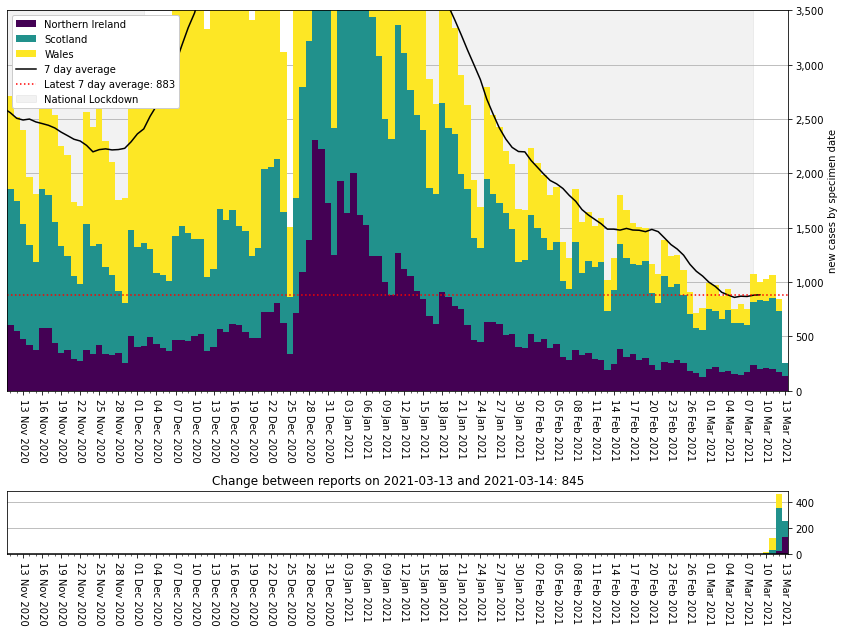

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=3_500, diff_ylims=None, earliest='2020-11-11')